In [1]:
from scipy import stats,special
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from random import choices
from glob import glob
import xarray as xr
import datetime as dt

# **Inverse Problems Primer**


#### First, a familiar example. Consider a multivariate linear model where we try to predict a variable $y$ with a linear combination of variables $x = [x_i]_{i=1}^{n}$ and potentially an intercept: $$y = \beta_0 + \sum_{i=1}^{n} \beta_i x_i = F(x).$$ We usually think about this type of model with the $\beta$ already specified, but we can also expand our thinking to include the entire family of such models $F(x;\beta)$, where "$;\beta$" notation is typical for parameters, but really just means $F$ is a function of both $x$ and $\beta$.

#### In the case that we have some data $\hat{y}$ with predictor samples $\hat{x}$, we can think of $F(x;\beta)$ as the forward model from the space of predictors $x$ and parameters $\beta$. If we specify $\beta$, then we have a specific multilinear model that we can compare against data.

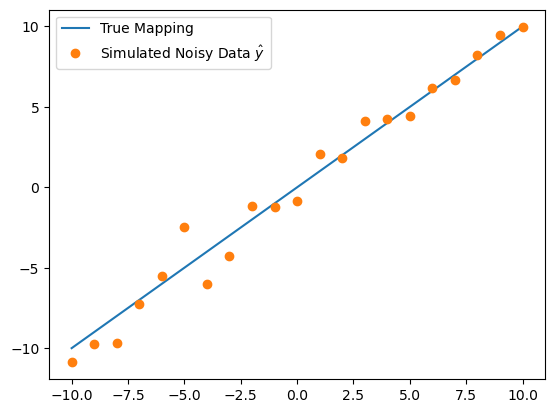

In [2]:
# True Parameters
beta_0 = 0
beta_1 = 1
x = np.linspace(-10,10,21)
y = beta_0 + beta_1*x
noise = np.random.randn(len(x))
yhat = y + noise

plt.plot(x,y)
plt.plot(x,yhat,'o')
plt.legend(['True Mapping','Simulated Noisy Data $\hat{y}$'])

### **Exercise** 
#### 1. Copy and paste the code below and modify it for the case of noise with a bias of 1 and standard deviation 3.

# **II. Inverse Problems as Optimal Estimation**
# II.A Distance as an Error Metric
### In the real world, we have $m$ observations of a quantity we want to predict $$\hat{y}= [\hat{y}_i]_{i=1}^{m}$$ organized as a vector and also $m$ observations of $n$ predictors organized as a $m\times n$ matrix $\hat{X} = [x_{ij}]_{i,j=1}^{m,n}$. We would like to use these data to hypothesize a model $F$ for the general mapping $x\rightarrow y$. 

### In our simple example we would likely guess a linear model $$ y = F(x;\beta) = \beta_0 + \beta_1 x.$$ With these assumptions, we can ask what parameters $\beta$ would result in the "best" forward model $F(x;\beta).$ 

### We define "best" meaning minimizing a **chosen distance** between  and $y=[y_i] = F([x_{i,:}];\beta)]_{i=1}^{m}$. Some typical choices are:
### $\cdot$ $\mathcal{L}^1$: $|\hat{y}-y|_1 = \sum_{i=1}^{m}|\hat{y}_i - y_i|$
### $\cdot$ $\mathcal{L}^2$: $|\hat{y}-y|_2 = \sqrt{\sum_{i=1}^{m}(\hat{y}_i - y_i)^2} = \sqrt{(\hat{y}-y)^{\mathsf{T}}(\hat{y}-y)}$ (i.e., the Euclidean distance, or the distance derived from the standard dot product of two vectors)
### $\cdot$ $\mathcal{L}^\infty$: $|\hat{y}-y|_\infty=\max_{i=1,...,m}|\hat{y}_i - y_i|$
### $\cdot$ $\mathcal{L}^2_W$:  $|\hat{y}-y|_W = \sqrt{(\hat{y}-y)^{\mathsf{T}}W(\hat{y}-y)}$ 
### In this last case, $W$ is a positive definite matrix that we think of as weighting the individual mismatches $\hat{y}_i-y_i$. 
### The code below computes these different error metrics for a randomly selected parameter vector $\beta$ and plots histograms.
#### *Extra Credit: why do the different metrics have the relative sizes evident in the histograms?*

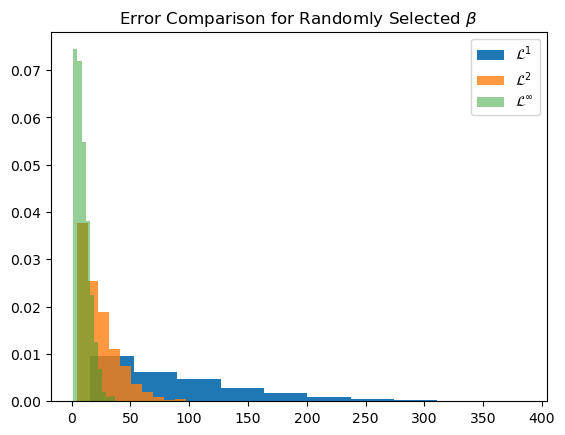

In [3]:
# Create noisy data
beta_0 = 0
beta_1 = 1
x = np.linspace(-10,10,21)
y = beta_0 + beta_1*x    #"truth" model output
noise = np.random.randn(len(x))
yhat = y + noise     # noisy data

# Error computation for our toy example
beta_0_test = np.random.randn(1000)
beta_1_test = np.random.randn(1000)+1
resids = np.array([yhat-beta_0_test[i]-beta_1_test[i]*x for i in range(1000)])
l1_errs = np.abs(resids).sum((1))
l2_errs = np.sqrt((resids**2).sum((1)))
linf_errs = np.max(np.abs(resids),(1))
plt.hist(l1_errs,density=True)
plt.hist(l2_errs,density=True,alpha=0.8)
plt.hist(linf_errs,density=True,alpha=0.5)
plt.legend(['$\mathcal{L}^1$','$\mathcal{L}^2$','$\mathcal{L}^\infty$'])
plt.title('Error Comparison for Randomly Selected $ \\beta$');


### The following plots show the $\mathcal{L}^2$ errors with a random sample of the intercept $\beta_0$ and $\beta_1$ parameters (1) in 2-D space, (2) in 1-D with fixed values of $\beta_1$, and (3) in 1-D with fixed values of $\beta_0.$ 

Text(0.5, 1.0, '$\\mathcal{L}^2$ Error versus Slope Parameter')

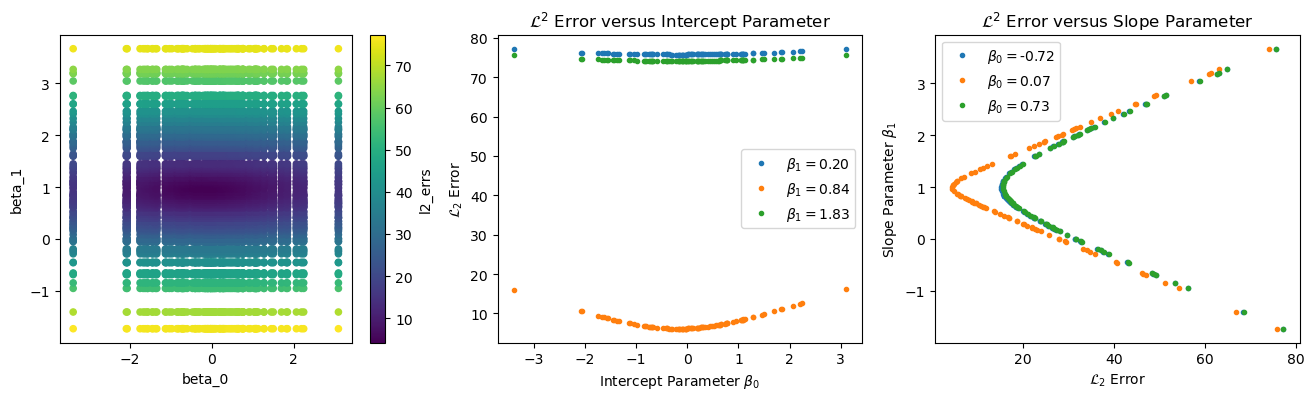

In [4]:
# Let's compute the errors with the beta values varying independently
beta_0_sub = sorted(beta_0_test[::10])
beta_1_sub = sorted(beta_1_test[::10])
resids = np.array([[yhat-beta_0_sub[i]-beta_1_sub[j]*x for i in range(len(beta_0_sub))] for j in range(len(beta_1_sub))])
l1_errs = np.abs(resids).sum((2))
l2_errs = np.sqrt((resids**2).sum((2)))
linf_errs = np.max(np.abs(resids),(2))

beta_0_test_2d,beta_1_test_2d = np.meshgrid(beta_0_sub,beta_1_sub)
df = pd.DataFrame({'beta_0':beta_0_test_2d.flatten(),'beta_1':beta_1_test_2d.flatten(),'l1_errs':l1_errs.flatten(),'l2_errs':l2_errs.flatten(),'linf_errs':linf_errs.flatten()})

# Now make the plots!
fig,axs = plt.subplots(1,3,figsize=(16,4))
df.plot.scatter(x='beta_0',y='beta_1',c='l2_errs',ax=axs[0])

#Plot a few slices with beta_1 constant
ax = axs[1]
g1 = ax.plot(beta_0_sub,l2_errs[0,:],'.')
g2 = ax.plot(beta_0_sub,l2_errs[50,:],'.')
g3 = ax.plot(beta_0_sub,l2_errs[-1,:],'.')
ax.legend([g1[0],g2[0],g3[0]],[f'$\\beta_1=${beta_1_sub[20]:4.2f}',f'$\\beta_1=${beta_1_sub[50]:4.2f}',f'$\\beta_1=${beta_1_sub[75]:4.2f}'])
ax.set_xlabel('Intercept Parameter $\\beta_0$')
ax.set_ylabel(r'$\mathcal{L}_2$ Error')
ax.set_title(r'$\mathcal{L}^2$ Error versus Intercept Parameter')

ax = axs[2]
g1 = ax.plot(l2_errs[:,0],beta_1_sub,'.')
g2 = ax.plot(l2_errs[:,50],beta_1_sub,'.')
g3 = ax.plot(l2_errs[:,-1],beta_1_sub,'.')
ax.legend([g1[0],g2[0],g3[0]],[f'$\\beta_0=${beta_0_sub[20]:4.2f}',f'$\\beta_0=${beta_0_sub[50]:4.2f}',f'$\\beta_0=${beta_0_sub[75]:4.2f}'])
ax.set_ylabel('Slope Parameter $\\beta_1$')
ax.set_xlabel(r'$\mathcal{L}_2$ Error')
ax.set_title(r'$\mathcal{L}^2$ Error versus Slope Parameter')


### Questions
#### 1. How does the $\mathcal{L}^2$ error vary in each parameter? Is it linear, quadratic, something else? Is it the same for both parameters? 
#### 2. Does the $\mathcal{L}^2$ error as a function of $\beta_0$ and $\beta_1$ have a minimum? Where? Why is that intuitive given how the simulated observations were created?

### Exercises
#### 1. Repeat the analysis and answer the questions for the $\mathcal{L}^1$ errors.


In [5]:
# L^1 Exercise

#### 2. Repeat the analysis and answer the questions for the $\mathcal{L}^\infty$ errors.

# II.B. Minimization of Distance
### Given a set of observations $(\hat{X},\hat{y})$, a model $y_\beta = F(x;\beta)$, and an error metric $|\cdot|$, we can ask the question:
### <center> IP1: *What parameter vector $\beta^*$ minimizes $|\hat{y}-y_\beta|$*? </center>
### This formulation intuitively chooses the best model $F(\hat{x};\beta^*)$ to reproduce the data $\hat{y}$ given our definition of distance. Sticking with our multilinear model example above (assuming no intercept): $$y = [F(x_i;\beta)]_{i=1}^{m} = \left[\sum_{j=1}^{n}\beta_j x_{ij}\right]_{i=1}^{m} = \hat{X}\beta$$ and the distance (or cost) $$ J(\beta) = |\hat{y}-y|_2^2 = (\hat{y}-\hat{X}\beta)^{\mathsf{T}}(\hat{y}-\hat{X}\beta), $$ which is typically called the "least squares cost function". Remembering our college algebra and calculus, we can find the minimium of this paraboloid when the gradient is 0: $$0 = \nabla J = \left[\frac{\partial J}{\partial \beta_i}\right]_{i=1}^{n} = -2 \hat{X}^{\mathsf{T}}\hat{y} + 2\hat{X}^{\mathsf{T}}\hat{X}\beta$$ or $$ \hat{X}^{\mathsf{T}}\hat{X}\beta = \hat{X}^{\mathsf{T}}\hat{y} $$ So now we have a typical linear algebra problem where we want to find $\beta$ that satisfies the $m$ linear equations. Remember that this problem could be overdetermined $(m < n)$ or underdetermined $(m > n)$ and that even if $m = n$ we can still have issues when $\hat{X}^{\mathsf{T}}\hat{X}$ is not invertible. 

## *Example*: Let's try an example where we generate some data from a secret "truth" $\beta$ and try to find the optimal solution $\beta^*$.

Optimal Model: y = -5.00 x_1 + 5.00 x_2
True Model: y = -5.00 x_1 + 5.00 x_2
Errors: beta_1 = -0.00%, beta_2 = 0.00%


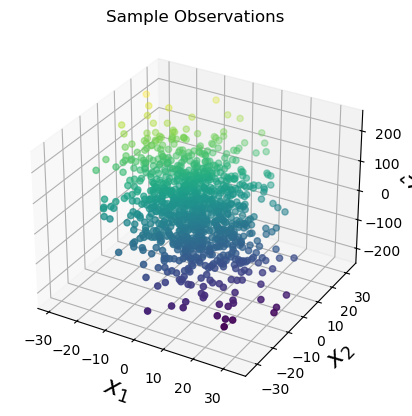

In [9]:
n_obs = 1000

# Noise is normally distributed with a bias and scatter
bias = 0.
scatter = 10.
noise = 0.#bias + scatter*np.random.randn(n_obs)

# Model looks like y = -5x_1 + 5x_2
bet = np.array([-5,5])

# Create truth observations 
x1 = 10*np.random.randn(n_obs)
x2 = 10*np.random.randn(n_obs)
X = np.c_[(x1,x2)]
y = np.dot(X,bet)   #"truth" model output
yhat = y + noise     # noisy data

# Find the optimal parameters
xtx = np.dot(X.T,X)
ytx = np.dot(yhat.T,X)
beta_star = np.dot(np.linalg.inv(xtx),ytx)

# Compute the prediction error
y_star = np.dot(X,beta_star)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x1,x2,yhat,c=yhat)
ax.set_xlabel(r'$x_1$',fontsize=18)
ax.set_ylabel(r'$x_2$',fontsize=18)
ax.set_zlabel(r'$\hat{y}$',fontsize=18)
ax.set_title('Sample Observations')

print(f'Optimal Model: y = {beta_star[0]:4.2f} x_1 + {beta_star[1]:4.2f} x_2')
print(f'True Model: y = {bet[0]:4.2f} x_1 + {bet[1]:4.2f} x_2')
print(f'Errors: beta_1 = {(beta_star[0]-bet[0])/bet[0]*100:4.2f}%, beta_2 = {(beta_star[1]-bet[1])/bet[1]*100:4.2f}%')


### Success! We were able to exactly recover the "true" parameters.

# II.C Noise and Uncertainty
### We saw in the last example that in the case of perfect data with sufficiently few parameters, we can exactly recover the true parameters. 
### Real observational data always contains uncertainty due to the limits of measurement technology and human operators. It is natural to ask how these uncertainties will affect our ability to estimate parameters, and what the uncertainty in our estimates of those parameters will be. Scientific understanding demands not just the optimal estimate $\beta^*$, but rather some notion of the uncertainty in the estimate. 

### In the simplest case, we assume that $$ y = X\beta + \epsilon $$ where $\epsilon$ is a random variable that captures the uncertainty in our ability to reproduce the behavior of $y$ with the model $F$, whether that is due to observational noise or model error. In order to proceed, we have to assume something about $\epsilon$, and it's typical to assume that $\epsilon \sim N(0,\Sigma)$, i.e., errors are normally distributed with zero bias and covariance $E\{\epsilon\epsilon^{\mathsf{T}}\} = \Sigma$. 

### Since we now have random variables, we seek to minimize the **expectation** of the square error: $$ E\{(\hat{y}-F(x;\beta))^{\mathsf{T}}(\hat{y}-F(x;\beta))\} = E\{|\hat{y}-F(x;\beta)|^2\} $$

### If we assume that the optimal estimate $\beta^*$ is unbiased, i.e., $E\{\beta^*\} = \hat{\beta}$, then we get the result that the point estimate $$ \beta^* = (X^\mathsf{T}\Sigma X)^{-1}(X^{\mathsf{T}}\Sigma^{-1}\hat{y}) $$ and that the corresponding error covariance is $$ E\{|\beta^*-\hat{\beta}|^2\} =  (X^\mathsf{T}\Sigma X)^{-1} $$.

### These are the errors in the simulated observations from the forward model with the parameter estimate $\beta^*$. 
## **Questions:**
### [1] What do you think might make the parameter estimate better? What might make it worse? 
### [2] Is the distribution of mismatches $\hat{y}-y^*$ a normal distribution? 
### [3] Is the distribution of mismatches biased? 
### [4] What is the scatter of the distribution? How is that tied to the assumptions we made? 

## **Exercises**
### [1] Copy and paste the code above below and reduce the number of observations to 100. How does that change the results? 

### [2] Copy and paste the code above to the box below and add a bias of 5 to the noise. How does that change the results?

## **Critical Thinking**
### In the simple example above, the observations were generated with the same model family we used in the optimization. What would happen if those two model families weren't the same? 